In [7]:
import pandas as pd
from scipy.spatial.distance import cosine
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import numpy as np
import umap
from adjustText import adjust_text

In [123]:
party = 'dem'

In [124]:
df_srl_emb = pickle.load(open('srl_elmo_{}_sample.tsv'.format(party),'rb'))

In [125]:
len(df_srl_emb)

25000

In [126]:
df_srl_emb.head(2)

,Text,Verb_annotation,Embeddings
71654,"['RT', '@GovMurphy', ':', 'As', 'we', 'continu...","{'verb': 'help', 'description': 'RT @GovMurphy...","[[0.064685374, -0.7511855, -0.6517378, -0.3875..."
89613,"['I', 'fought', 'to', 'secure', 'more', 'than'...","{'verb': 'fought', 'description': '[ARG0: I] [...","[[0.03503506, -0.7775535, -0.66809475, -0.3998..."


In [127]:
# df_srl_emb_sample = df_srl_emb.sample(25000)

In [128]:
# pickle.dump(df_srl_emb_sample, open('srl_elmo_dem_sample.tsv', 'wb'))

In [129]:
args_list_all = []
for idx, row in df_srl_emb.iterrows():
    annotation = eval(row['Verb_annotation'])
    verb = annotation['verb']
    verb_idx = eval(row['Text']).index(verb)
    verb_emb = row['Embeddings'][verb_idx]
    arg0_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG0' in tag]
    if len(arg0_idx) > 0 and len(arg0_idx) <= 3:
        arg0_emb = np.array([row['Embeddings'][idx] for idx in arg0_idx])
        if arg0_emb.shape[0] > 1:
            arg0_emb = np.sum(arg0_emb, axis=0)
            arg0_emb = np.expand_dims(arg0_emb, axis=0)
        arg0_tok = [eval(row['Text'])[idx] for idx in arg0_idx]
        arg0_tok = ' '.join([item for item in arg0_tok])
    else:
        arg0 = 'No_arg0'
        arg0_idx = -1
        arg0_emb = -1
        arg0_tok = 'No_arg0'


    arg1_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG1' in tag]
    if len(arg1_idx) > 0  and len(arg1_idx) <= 3:
        arg1_emb = np.array([row['Embeddings'][idx] for idx in arg1_idx])
        if arg1_emb.shape[0] > 1:
            arg1_emb = np.sum(arg1_emb, axis=0)
            arg1_emb = np.expand_dims(arg1_emb, axis=0)
        arg1_tok = [eval(row['Text'])[idx] for idx in arg1_idx]
        arg1_tok = ' '.join([item for item in arg1_tok])

    else:
        arg1 = 'No_arg1'
        arg1_idx = -1
        arg1_emb = -1
        arg1_tok = 'No_arg1'


    args_list_all.append([verb, verb_idx, verb_emb, arg0_tok, arg0_idx, arg0_emb, arg1_tok, \
                          arg1_idx, arg1_emb])

In [130]:
df_args = pd.DataFrame(args_list_all, columns=['Verb', 'Verb_idx', 'Verb_emb', 'Arg0_tok', 'Arg0_idx',\
                                               'Arg0_emb', 'Arg1_tok', 'Arg1_idx', 'Arg1_emb'])

In [131]:
def extract_verb_agents(verb, arg_option):
    df_verb =df_args[df_args.Verb == verb]
    df_verb = df_verb[df_verb['Arg{}_idx'.format(arg_option)] != -1]
    df_verb_agg = df_verb.groupby('Arg{}_tok'.format(arg_option)).apply\
                                    (lambda x: np.average(x['Arg{}_emb'.format(arg_option)], axis=0)).reset_index()
    df_verb_agg.columns = ['Arg{}_tok'.format(arg_option), 'Arg{}_emb'.format(arg_option)]
    pca_reduc = PCA(n_components=50).fit_transform(np.array(df_verb_agg['Arg{}_emb'.format(arg_option)].tolist()).squeeze())
    umap_reduc = umap.UMAP(min_dist=0.0,n_neighbors=5).fit_transform(pca_reduc)
    df_verb_agg['umap_emb_x'] = umap_reduc[:,0]
    df_verb_agg['umap_emb_y'] = umap_reduc[:,1]
    return df_verb_agg

In [132]:
df_verb_agg = extract_verb_agents('have', 1)

In [133]:
df_verb_agg.head(2)

,Arg1_tok,Arg1_emb,umap_emb_x,umap_emb_y
0,# statehood status,"[[0.9772096, 1.3407311, -0.33974698, -0.539083...",11.964536,7.417711
1,COVID-19,"[[0.3759799, 0.025790231, 0.20122454, -0.17593...",9.638382,10.728443


In [134]:
# df_args[(df_args['Arg0_tok'] == 'Mitch') & (df_args['Verb'] == 'fighting')]

In [135]:
# ' '.join(item for item in eval(df_srl_emb.iloc[34590]['Text']))

In [138]:
def plot_agent_verb(df, verb, arg_option, party):
#     df = df.sample(80)
    x = df['umap_emb_x'].tolist()
    y = df['umap_emb_y'].tolist()
    text = df['Arg{}_tok'.format(arg_option)].tolist()
    plt.figure(figsize=(15, 15))
    plt.scatter(x,y, s=10)
    texts = [plt.text(x[idx], y[idx], text[idx], fontsize=12) for idx in range(len(text))]
    adjust_text(texts, expand_text=(1.02, 1.02), force_text=(0.75, 0.75), save_steps=True, lim=20)
    plt.title('Arg {} of verb {}, {} party'.format(arg_option, verb, party))
    plt.savefig('arg_{}_verb_{}_party_{}.png'.format(arg_option, verb, party), format='png')

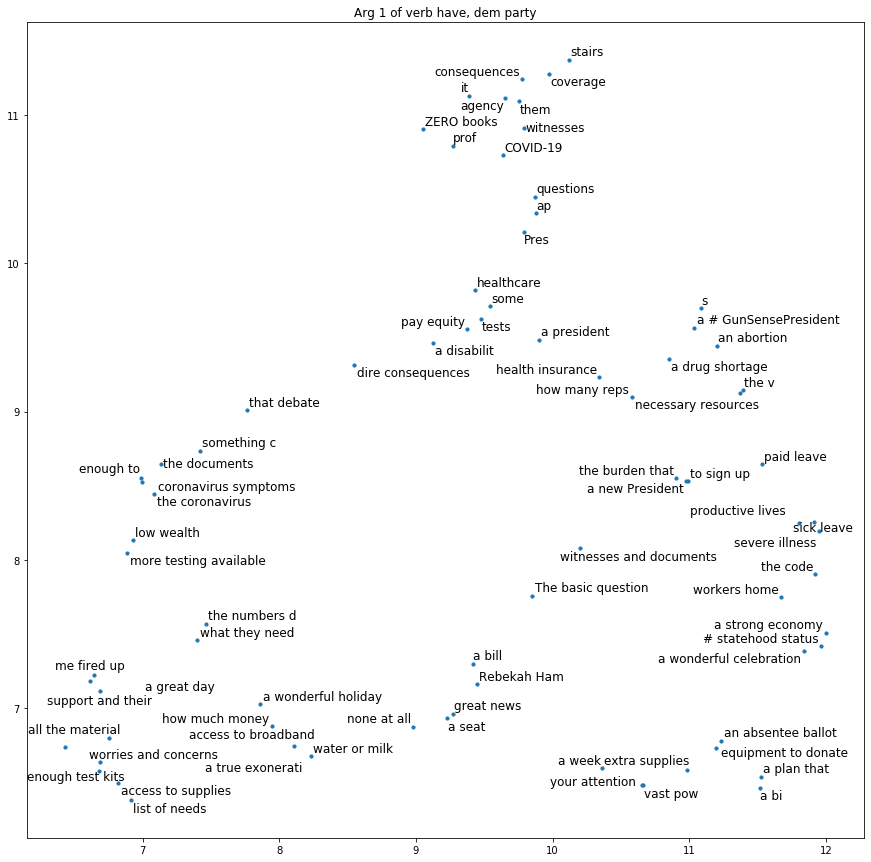

In [139]:
plot_agent_verb(df_verb_agg, 'have', 1, party)

In [114]:
df_args.Verb.value_counts().head(50)

is           1403
are           920
will          659
be            580
have          555
can           405
has           397
help          362
do            274
was           272
need          231
working       228
been          212
get           209
Thank         194
should        180
keep          173
continue      145
must          136
's            133
provide       130
’m            130
work          128
ensure        127
make          126
would         124
see           116
protect       115
discuss       114
’re            99
take           97
know           96
am             94
support        93
being          84
join           83
passed         82
stop           80
including      79
’ve            77
want           77
had            75
'm             73
were           73
going          72
doing          71
go             70
receive        70
made           69
does           69
Name: Verb, dtype: int64